# Bandwidths 

Based on kde_tutorial from https://notebooks.gesis.org/binder/jupyter/user/saint-germain-p-ation_synthesis-uu00810x/tree/prep

In [1]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
dn=pd.read_csv('proc_no_pert.csv',index_col=None) #without pertubtations 
dn["gia"]=dn.ngi>0
dl=pd.read_csv('proc_lo_pert.csv',index_col=None) #with low pertubtations 
dl["gia"]=dl.ngi>0
dh=pd.read_csv('proc_hi_pert.csv',index_col=None) #with high pertubtations 
dh["gia"]=dh.ngi>0

In [5]:
#Terrestrial
dnt=dn[~dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]] # high pertubtations 

#Giant 
dng=dn[dn["gia"]]  # without pertubtations 
dlg=dl[dl["gia"]]  # low pertubtations 
dhg=dh[dh["gia"]]  # high without pertubtations 

In [6]:
print("***************************************")
print("Total systems                  : "+str(len(dn)))
print("***************************************")
print("Total planets - no             : "+str(dn.nplanets.sum().astype(int)))
print("Giant planets - no             : "+str(dn.ngi.sum().astype(int)))
print("Systems with giant planets - no: "+str(dn.gia.sum()))
print("***************************************")

print("Total planets - lo             : "+str(dl.nplanets.sum().astype(int)))
print("Giant planets - lo             : "+str(dl.ngi.sum().astype(int)))
print("Systems with giant planets - lo: "+str(dl.gia.sum()))
print("***************************************")
print("Total planets - hi             : "+str(dh.nplanets.sum().astype(int)))
print("Giant planets - hi             : "+str(dh.ngi.sum().astype(int)))
print("Systems with giant planets - hi: "+str(dh.gia.sum()))

***************************************
Total systems                  : 1221
***************************************
Total planets - no             : 15887
Giant planets - no             : 330
Systems with giant planets - no: 268
***************************************
Total planets - lo             : 15732
Giant planets - lo             : 374
Systems with giant planets - lo: 306
***************************************
Total planets - hi             : 15441
Giant planets - hi             : 388
Systems with giant planets - hi: 309


Some important variables: 

In [7]:
#log_10 of mass efficiency and center of mass
#log_10 mass efficiency giant and terrestrial 
dng['logeff']=np.log10(dng.massefficiency)
dlg['logeff']=np.log10(dlg.massefficiency)
dhg['logeff']=np.log10(dhg.massefficiency)
dnt['logeff']=np.log10(dnt.massefficiency)
dlt['logeff']=np.log10(dlt.massefficiency)
dht['logeff']=np.log10(dht.massefficiency)#
#log_10 total mass efficiency
dn['logeff']=np.log10(dn.massefficiency)
dl['logeff']=np.log10(dl.massefficiency)
dh['logeff']=np.log10(dh.massefficiency)

#log_10 total com
dn['logcom']=np.log10(dn.com)
dl['logcom']=np.log10(dl.com)
dh['logcom']=np.log10(dh.com)

#log_10 com giant and terrestrial 
dng['logcom']=np.log10(dng.com)
dlg['logcom']=np.log10(dlg.com)
dhg['logcom']=np.log10(dhg.com)
dnt['logcom']=np.log10(dnt.com)
dlt['logcom']=np.log10(dlt.com)
dht['logcom']=np.log10(dht.com)

In [8]:
dng.head()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert,gia,logeff,logcom
0,0,3.0,1.081461,10.0,10770.309627,0.576981,90.793337,0.056,29.539343,0.880114,0.328146,1644710.625,8.421395,4.0,12.004623,0.0,True,-0.238839,0.034011
2,2,6.0,0.110789,12.0,2422.342359,0.060559,75.740878,0.120,47.343380,0.861595,0.021273,1790533.125,4.412694,1.0,29.771089,0.0,True,-1.217824,-0.955504
4,4,13.0,0.172211,13.0,2905.457535,0.051273,178.830700,0.170,36.672222,1.206445,-0.174039,3956707.500,3.998513,1.0,14.220447,0.0,True,-1.290113,-0.763939
16,16,31.0,4.377862,11.0,41.578462,0.001299,86.546084,0.096,39.613728,0.993549,-0.031508,1439538.875,5.991912,1.0,17.716253,0.0,True,-2.886282,0.641262
23,23,40.0,2.144859,13.0,181.982608,0.006578,57.698437,0.083,45.111870,1.037112,0.039315,2374519.750,7.413428,1.0,14.782324,0.0,True,-2.181927,0.331399


## Bandwidth problem

an example with kernel density

In [9]:
# an example with kernel density
x=dng.ngi
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=50) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

# other example with gaussian_kde method. 
from scipy.stats import gaussian_kde
kde = gaussian_kde(x)
f = kde.covariance_factor()
bw = f * x.std()
print("bw g_kde: "+str(bw))

{'bandwidth': 0.4}
bw g_kde: 0.17399675736725956


(array([2.71144279, 0.        , 0.        , 0.49751244, 0.        ,
        0.        , 0.09950249, 0.        , 0.        , 0.02487562]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

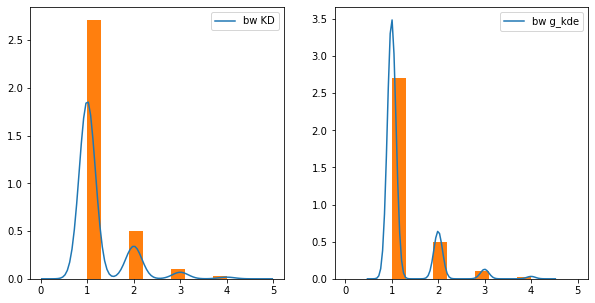

In [10]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.kdeplot(dng.ngi,bw=.32688, ax=axes[0], label="bw KD"); axes[0].hist(dng.ngi, density=True)
sns.kdeplot(dng.ngi,bw=bw, ax=axes[1],label="bw g_kde"); axes[1].hist(dng.ngi, density=True)

Now, a function to compare this methods: 

In [50]:
x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]
#columns     = [str(logeff), str(logcom)]

def bw_optimal(variables): 
    bw_optimal_CV, bw_optimal_kde = [],[]
    norm, size, cv = 10, 30, 20 # 20-fold cross-validation
    
    for index,variable in enumerate(variables):
        x = variable.logeff/variable.logeff.min()
        
        #-------------With CrossValidation:
        grid = GridSearchCV(KernelDensity(), 
                            {'bandwidth': np.linspace(x.min(),x.max()/norm,size)}, 
                            cv=cv)
        grid.fit(x[:, None])
        bw_optimal_CV.append(list(grid.best_params_.values())[0])
        
        #-------------Gaussian_KDE:
        kde = gaussian_kde(x)
        f = kde.covariance_factor()
        bw_optimal_kde.append(f * x.std())
        
    return bw_optimal_CV
'''
        x_i  = variables[index]/(variables[index].min())
        #CV
        grid = GridSearchCV(KernelDensity(), 
                            {'bandwidth': np.linspace(x_i.min(),x_i.max()/norm,size)}, 
                            cv=cv)
        grid.fit(x_i[:, None])
        bw_CV = list(grid.best_params_.values())[0]
        bw_optimal_CV.append(bw_CV)
        
        #KDE:
        kde = gaussian_kde(x_i)
        f = kde.covariance_factor()
        bw_kde = f * x_i.std()
        bw_optimal_kde.append(bw_kde)
    
    return [bw_optimal_CV, bw_optimal_kde]'''

"\n        x_i  = variables[index]/(variables[index].min())\n        #CV\n        grid = GridSearchCV(KernelDensity(), \n                            {'bandwidth': np.linspace(x_i.min(),x_i.max()/norm,size)}, \n                            cv=cv)\n        grid.fit(x_i[:, None])\n        bw_CV = list(grid.best_params_.values())[0]\n        bw_optimal_CV.append(bw_CV)\n        \n        #KDE:\n        kde = gaussian_kde(x_i)\n        f = kde.covariance_factor()\n        bw_kde = f * x_i.std()\n        bw_optimal_kde.append(bw_kde)\n    \n    return [bw_optimal_CV, bw_optimal_kde]"

In [51]:
%%time
AA =  bw_optimal(x_variables)
AA

CPU times: user 18.1 s, sys: 63.7 ms, total: 18.2 s
Wall time: 18 s


[0.06861681279645619,
 0.06651027180474715,
 0.1,
 0.1,
 0.1,
 0.1,
 0.04159322848746282,
 0.04718116625880585,
 0.06989983400956606]

In [13]:
'''
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.kdeplot(AA[0],bw=AA[1], ax=axes[0], label="bw CV"); axes[0].hist(AA[0], density=True)
sns.kdeplot(AA[0],bw=AA[2], ax=axes[1],label="bw g_kde"); axes[1].hist(AA[0], density=True)
axes[0].set_xlim(-0.,1.05)
axes[1].set_xlim(-0.,1.05)
'''

[[0.06861681279645619,
  0.06651027180474715,
  0.1,
  0.1,
  0.1,
  0.1,
  0.04159322848746282,
  0.04718116625880585,
  0.06989983400956606],
 [0.07616826615220967,
  0.07283586344782506,
  0.0766064903211836,
  0.01528846088540147,
  0.016623501511828866,
  0.015880643899511,
  0.03638012506581476,
  0.043349312602960134,
  0.04384632923104626]]

{'bandwidth': 0.1}


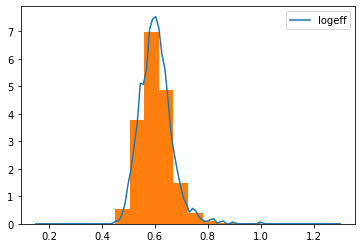

In [14]:
x=dnt.logeff/dnt.logeff.values.min() # maping data through normalization
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

sns.kdeplot(x,bw=list(grid.best_params_.values())[0])
plt.hist(x, density=True)
plt.show()

In [15]:
x

1       0.576749
3       0.659488
5       0.585149
6       0.637203
7       0.538279
          ...   
1215    0.595577
1217    0.520010
1218    0.554502
1219    0.592505
1220    0.572600
Name: logeff, Length: 953, dtype: float64

0.01528846088540147


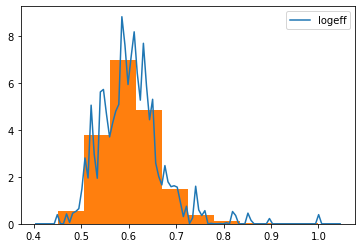

In [16]:
kde = gaussian_kde(x)
f = kde.covariance_factor()
bw = f * x.std()
f
print(bw)

sns.kdeplot(x,bw=bw)
plt.hist(x, density=True)
plt.show()


In [17]:



dng['logeff']=np.log10(dng.massefficiency)
dlg['logeff']=np.log10(dlg.massefficiency)
dhg['logeff']=np.log10(dhg.massefficiency)
dnt['logeff']=np.log10(dnt.massefficiency)
dlt['logeff']=np.log10(dlt.massefficiency)
dht['logeff']=np.log10(dht.massefficiency)#
#log_10 total mass efficiency
dn['logeff']=np.log10(dn.massefficiency)
dl['logeff']=np.log10(dl.massefficiency)
dh['logeff']=np.log10(dh.massefficiency)

#log_10 total com
dn['logcom']=np.log10(dn.com)
dl['logcom']=np.log10(dl.com)
dh['logcom']=np.log10(dh.com)

#log_10 com giant and terrestrial 
dng['logcom']=np.log10(dng.com)
dlg['logcom']=np.log10(dlg.com)
dhg['logcom']=np.log10(dhg.com)
dnt['logcom']=np.log10(dnt.com)
dlt['logcom']=np.log10(dlt.com)
dht['logcom']=np.log10(dht.com)

In [18]:
x=dng.ngi
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(x.min(),x.max()/10,30)},
                    cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

{'bandwidth': 0.4}


In [19]:
grid.best_params_.values()

dict_values([0.4])

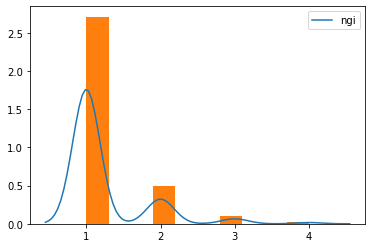

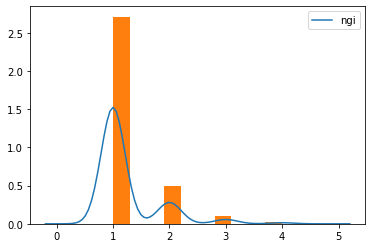

In [20]:
#comparative of bw estimation
sns.kdeplot(dng.ngi,bw='silverman')
plt.hist(dng.ngi, density=True)
plt.show()
sns.kdeplot(dng.ngi,bw=0.4)
plt.hist(dng.ngi, density=True)
plt.show()

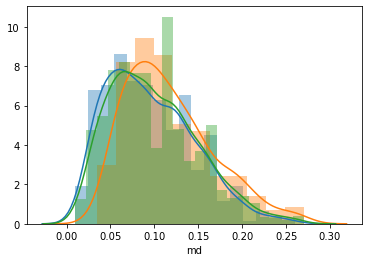

In [21]:
var='md'
sns.distplot(dnt[var])
sns.distplot(dng[var])
sns.distplot(dn[var])

In [22]:
x=dn.md/dn.ms
grid = GridSearchCV(KernelDensity(),
                {'bandwidth': np.linspace(0.01, 0.5, 30)},
                cv=20) # 20-fold cross-validation
grid.fit(x[:, None])
print(grid.best_params_)

{'bandwidth': 0.01}


(array([2.24576629, 6.30542074, 7.94655764, 6.91005012, 6.34860855,
        5.83035479, 5.61441573, 4.2324057 , 4.01646663, 3.28227381]),
 array([0.01005764, 0.02902134, 0.04798505, 0.06694875, 0.08591245,
        0.10487615, 0.12383985, 0.14280356, 0.16176726, 0.18073096,
        0.19969466]),
 <a list of 10 Patch objects>)

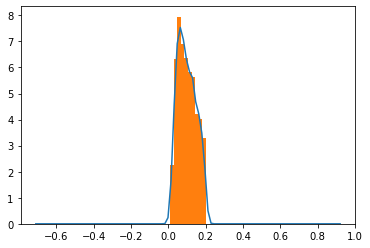

In [23]:
sns.kdeplot(x,bw=0.24)
plt.hist(x, density=True)